# AMO - Atlantic Multi-decadal Oscillation

The Atlantic Multi-decadal Oscillation (AMO) is a climate pattern characterized by long-term fluctuations in sea surface temperatures in the North Atlantic Ocean, typically occurring over periods of 20 to 40 years. It influences climate variability across the Northern Hemisphere, affecting phenomena such as rainfall patterns, hurricane activity, and regional temperatures.

Download: https://psl.noaa.gov/data/timeseries/AMO/

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.io import write_image

In [10]:
col_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df = pd.read_csv('https://psl.noaa.gov/data/correlation/amon.us.data', sep='\s+', skiprows=1, names=col_names) 
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
df.replace({-99.90 : np.NaN}, inplace=True)
df = df.drop(df.index[:2])
df = df.drop(df.tail(3).index) #working with data until 2021.

<>:2: SyntaxWarning:

invalid escape sequence '\s'

<>:2: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\cb3910\AppData\Local\Temp\ipykernel_234096\2329119740.py:2: SyntaxWarning:

invalid escape sequence '\s'



In [14]:
fig = px.imshow(df.T,
                color_continuous_scale='RdBu_r',
                title='# AMO - Atlantic Multi-decadal Oscillation',
                labels=dict(x="Year", y="Month", color="ONI"),
                aspect='auto')

#write_image(fig, 'FigureAMO_month.svg', scale=1) 

fig.show()

In [15]:
df =  df.reset_index().rename(columns={'index': 'YR'})
df = pd.melt(df, id_vars=['YR'], 
                    var_name='MON', 
                    value_name='ANOM')

# Map months names to numbers
month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 
             'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

df['MON'] = df['MON'].map(month_map)

# Sort by year and month for a cleaner look
df = df.sort_values(by=['YR', 'MON']).reset_index(drop=True)

In [16]:
AMO_year = df.groupby(['YR']).mean()
AMO_year = AMO_year.reset_index()
AMO_year["YR"] = AMO_year["YR"].astype(int)

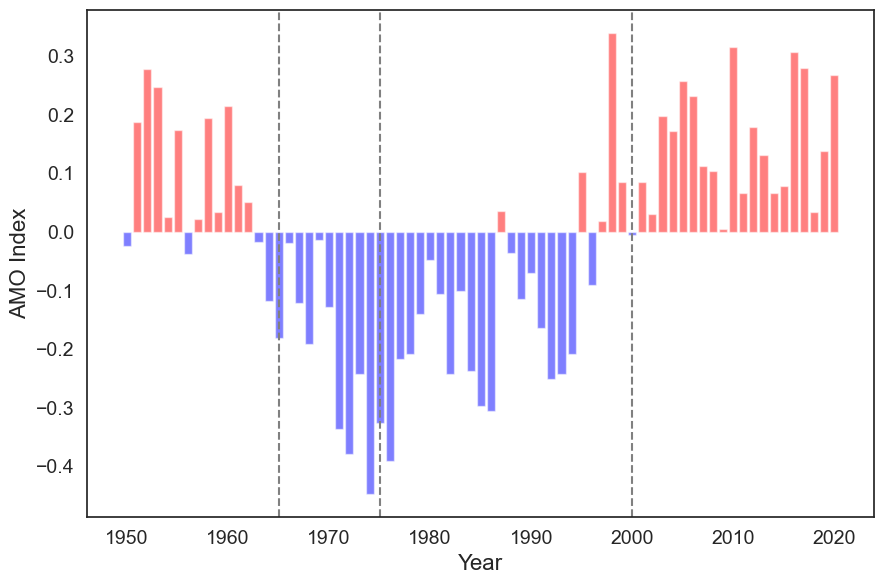

In [17]:
years = list(range(1950, 2021))
anomalies = AMO_year["ANOM"]

sns.set(style="white",
        rc={"font.family": "sans-serif", "font.sans-serif": ["Arial", "Helvetica", "Verdana", "Trebuchet MS"]})

fig, ax = plt.subplots(figsize=(9, 6))

for year, anomalies in zip(years, anomalies):
    if anomalies > 0:
        color = 'red'
    else:
        color = 'blue'

    ax.bar(year, anomalies, color=color, alpha=0.5)


plt.axvline(x=1965, color='grey', linestyle='--')
plt.axvline(x=1975, color='grey', linestyle='--')
plt.axvline(x=2000, color='grey', linestyle='--')


# Set labels and title
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('AMO Index', fontsize=16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)


# Rotate x-axis labels for better readability
#plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.savefig('FigureAMO.tiff', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 800x600 with 0 Axes>

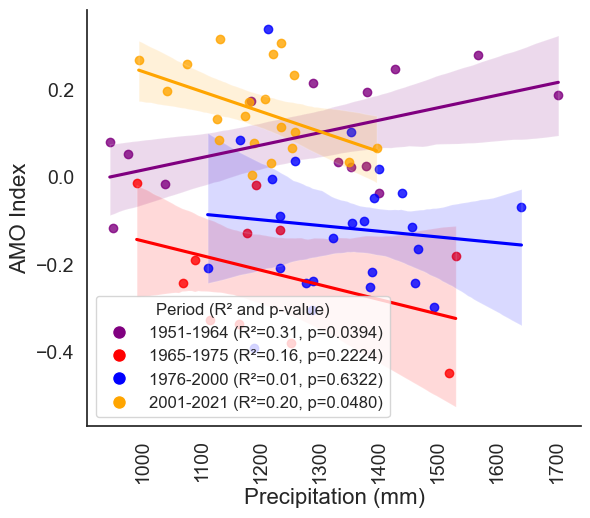

In [21]:
import statsmodels.api as sm

## Correlation with PRECIP
PRECIP = pd.read_csv(
    r'G:\My Drive\Doutorado\TESE\2. Artigo 2\Artigo Pantanal - LULCC\Codes\pantanal-lc\2024_reviews\Data\merged_Precip.csv',
    usecols=['hydro_year', 'Precip_basin'])

df = pd.merge(AMO_year, PRECIP, left_on='YR', right_on='hydro_year')

# Plot lmplot for each period
plt.figure(figsize=(8, 6))  # Adjust the figure size here

# Divide the dataset into three periods
periods = pd.cut(df['hydro_year'], bins=[1950, 1964, 1975, 2000, 2022],
                 labels=['1951-1964', '1965-1975', '1976-2000', '2001-2021'])
df['Period'] = periods

# Initialize a dictionary to store R-squared and p-values for each period
rsquared_pvalue_dict = {}

# Initialize a list to store legend handles
legend_handles = []

palette = ["purple", "red", 'blue', 'orange']
# Define a unique set of colors and markers for the legend handles
unique_colors = sns.color_palette(palette, len(df['Period'].unique()))
markers = ['o', 'o', 'o', 'o']  # You can choose any marker styles you prefer

g = sns.lmplot(x="Precip_basin", y="ANOM", data=df, hue='Period', palette=["purple", "red", 'blue', 'orange'],
               height=5, aspect=1.2)

# Iterate through each period to fit a linear regression model and calculate R-squared and p-value
for i, period in enumerate(df['Period'].unique()):
    subset = df[df['Period'] == period]
    X = sm.add_constant(subset['Precip_basin'])
    model = sm.OLS(subset['ANOM'], X).fit()
    rsquared = model.rsquared
    p_value = model.f_pvalue  # This calculates the p-value for the overall model
    rsquared_pvalue_dict[period] = (rsquared, p_value)

    # Create a legend handle with the appropriate color and marker
    legend_handles.append(plt.Line2D([0], [0], marker=markers[i], color='w', markerfacecolor=unique_colors[i],
                                     markersize=10, label=f'{period} (R²={rsquared:.2f}, p={p_value:.4f})'))
g._legend.remove()

# Set axis labels
plt.xlabel('Precipitation (mm)', fontsize=16)
plt.ylabel('AMO Index', fontsize=16)

#plt.xlim(700, 1800)
#plt.ylim(0, 300)

# Increase the x and y-axis tick label font sizes
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)

# Create a legend outside the lmplot with a specified title fontsize
plt.legend(title="Period (R² and p-value)", handles=legend_handles, loc='lower left', fontsize=12, title_fontsize=12)
#plt.savefig('Figure.tiff', dpi=300, bbox_inches='tight')
plt.show()